# **Dependencies and raw data**



**Importing dependencies**

In [ ]:
!pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import sys
import pydub
from scipy import signal
from scipy.io import wavfile
import matplotlib.pyplot as plt
import librosa
import librosa.display

#Order of emotion in one_hot: Anger, Disgust, Fear, Happy, Neutral, Sad
emotions = np.array(['ANG','DIS','FEA','HAP','NEU','SAD'])

In [ ]:
from google.colab import drive
drive._mount('/content/gdrive')

Mounted at /content/gdrive


Data from CREMA-D dataset

In [ ]:
cd '/content/'

/content


In [ ]:
%cd /content/gdrive/My\ Drive/Colab Notebooks/Voice_CNN/

/content/gdrive/My Drive/Colab Notebooks/Voice_CNN


In [ ]:
!pwd

/content/gdrive/My Drive/Colab Notebooks/Voice_CNN


In [ ]:
!git clone https://github.com/CheyneyComputerScience/CREMA-D.git

Cloning into 'CREMA-D'...
remote: Enumerating objects: 22501, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 22501 (delta 22), reused 57 (delta 13), pack-reused 22428
Receiving objects: 100% (22501/22501), 14.82 MiB | 19.18 MiB/s, done.
Resolving deltas: 100% (75/75), done.
Updating files: 100% (22342/22342), done.
Filtering content: 100% (22326/22326), 3.42 GiB | 9.14 MiB/s, done.


In [ ]:
cd '/content/gdrive/MyDrive/Colab Notebooks/Voice_CNN/CREMA-D'

/content/gdrive/MyDrive/Colab Notebooks/Voice_CNN/CREMA-D


In [ ]:
cd '/content/CREMA-D/'

/content/CREMA-D


# Testing

(129, 171)

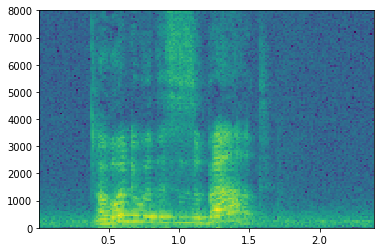

In [ ]:
sample_rate, samples = wavfile.read('AudioWAV/1039_IWW_HAP_XX.wav')
frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate)
spectrogram = np.log(spectrogram)
plt.pcolormesh(times, frequencies, spectrogram, shading='flat')
spectrogram.shape

In [ ]:
audio_file =r'AudioWAV/1037_IOM_ANG_XX.wav'
audio_data, sr = librosa.load(audio_file, sr= 8000, mono=True)
melspectrum = librosa.feature.melspectrogram(y=audio_data, sr=sr, hop_length= 512, window='hann', n_mels=256)
print(melspectrum.shape)
print(librosa.get_duration(filename='AudioWAV/1037_IOM_ANG_XX.wav'))

(256, 44)
2.7694375


In [ ]:
melspectrum = np.concatenate((np.array(melspectrum),np.zeros([256,79-melspectrum.shape[1]])), axis = 1)

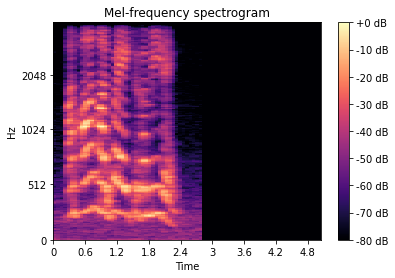

In [ ]:
fig, ax = plt.subplots()
S_dB = librosa.power_to_db(melspectrum, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')
plt.show()

# **Converting voice data to spectrogram**

In [ ]:
entry = len(os.listdir('AudioWAV'))

(array([ 104.,  926., 2032., 2178., 1395.,  483.,  202.,   81.,   28.,
          13.]),
 array([1.2679375 , 1.64164375, 2.01535   , 2.38905625, 2.7627625 ,
        3.13646875, 3.510175  , 3.88388125, 4.2575875 , 4.63129375,
        5.005     ]),
 <a list of 10 Patch objects>)

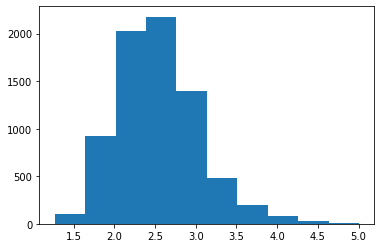

In [ ]:
audiolength = np.empty([len(os.listdir('AudioWAV'))])
for i in range(len(os.listdir('AudioWAV'))):
  audiolength[i] = librosa.get_duration(filename=('AudioWAV/' + os.listdir('AudioWAV')[i]))

plt.hist(audiolength)

In [ ]:
one_hot = np.zeros([len(os.listdir('AudioWAV')),6])
for i in range(len(os.listdir('AudioWAV'))):
  temp = os.listdir('AudioWAV')[i][9:12]
  one_hot[i][np.where(emotions == temp)[0][0]] = 1
one_hot[:10]

array([[0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0.]])

#**Audio padding**

In [ ]:
pad_ms = max(audiolength)*1000
max_length = 0
min_a = 0
max_a = 0

In [ ]:
all_mels = []

In [ ]:
all_mels_padded = []

In [ ]:
for i in range(len(os.listdir('AudioWAV'))):
  audio_data, sr = librosa.load('AudioWAV/'+os.listdir('AudioWAV')[i], sr= 8000, mono=True)
  melspectrum = librosa.feature.melspectrogram(y=audio_data, sr=sr, hop_length= 512, window='hann', n_mels=256)
  melspectrum = np.log(np.array(melspectrum))
  all_mels.append(melspectrum)
  max_length = max(max_length,melspectrum.shape[1])
  melspectrum = np.nan_to_num(melspectrum, copy=False, nan=0.0, posinf=0.0, neginf=0.0)
  min_a = min(melspectrum.min(),min_a)
  max_a = max(melspectrum.max(),max_a)

<ipython-input-13-f8554d638d94>:4: RuntimeWarning: divide by zero encountered in log
  melspectrum = np.log(np.array(melspectrum))


In [ ]:
for i in range(len(os.listdir('AudioWAV'))):
  audio_data, sr = librosa.load('AudioWAV/'+os.listdir('AudioWAV')[i], sr= 8000, mono=True)
  melspectrum = librosa.feature.melspectrogram(y=audio_data, sr=sr, hop_length= 512, window='hann', n_mels=256)
  melspectrum = (np.log(np.array(melspectrum))-min_a)/(max_a-min_a)
  melspectrum = np.concatenate((melspectrum,np.zeros([256,max_length-melspectrum.shape[1]])), axis = 1)
  melspectrum = np.nan_to_num(melspectrum, copy=False, nan=0.0, posinf=0.0, neginf=0.0)
  all_mels_padded.append(np.asarray(melspectrum, dtype = np.float32))

<ipython-input-14-8b96b1d9b4ba>:4: RuntimeWarning: divide by zero encountered in log
  melspectrum = (np.log(np.array(melspectrum))-min_a)/(max_a-min_a)


In [ ]:
all_mels_padded = np.array(all_mels_padded)
np.nan_to_num(np.array, copy=False, nan=0.0, posinf=0.0, neginf=0.0)
all_mels_padded.max()

1.0

# Preprocess Export

In [ ]:
%cd /content/gdrive/My\ Drive/Colab Notebooks/Voice_CNN/

/content/gdrive/My Drive/Colab Notebooks/Voice_CNN


In [ ]:
np.save('audiolength', audiolength)
np.save('one_hot', one_hot)
np.save('stats', [min_a,max_a,max_length,entry])
np.save('all_mels_padded', all_mels_padded)